# Scoring products of Digikala

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
digikala = pd.read_csv('comments_with_sentiment.csv')
digikala.head()

,id,title,body,created_at,rate,recommendation_status,is_buyer,product_id,likes,dislikes,seller_title,seller_code,true_to_size_rate,advantages_count,disadvantages_count,label
0,53672599,1,3,23 شهریور 1402,1.0,1.0,True,252058,0,0,دیجی‌کالا,5A52N,0,0,0,negative
1,9897229,1,10,16 تیر 1399,0.0,1.0,True,252058,1,0,دیجی‌کالا,5A52N,0,1,1,positive
2,9897229,1,10,16 تیر 1399,0.0,1.0,True,252058,1,0,دیجی‌کالا,5A52N,0,1,1,positive
3,38074516,1,19,26 مرداد 1401,0.0,1.0,True,3331597,0,0,آرالیا بیوتی,ADM47,0,0,0,positive
4,38074516,1,19,26 مرداد 1401,0.0,1.0,True,3331597,0,0,آرالیا بیوتی,ADM47,0,0,0,positive


In [3]:
digikala.describe()

,id,title,body,rate,recommendation_status,product_id,likes,dislikes,true_to_size_rate,advantages_count,disadvantages_count
count,6.157413e+06,6.157413e+06,6.157413e+06,6.157413e+06,6.157413e+06,6.157413e+06,6.157413e+06,6.157413e+06,6.157413e+06,6.157413e+06,6.157413e+06
mean,3.704755e+07,5.346132e-01,1.009031e+01,3.648097e+00,8.064453e-01,3.908869e+06,4.507716e-01,8.694138e-02,1.474467e-02,2.183667e-01,8.682770e-02
std,1.393319e+07,4.988005e-01,1.336918e+01,1.861786e+00,3.632494e-01,3.015891e+06,2.350727e+00,8.326633e-01,1.205291e-01,7.193049e-01,3.718183e-01
min,9.815860e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,7.602000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.731210e+07,0.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,1.532357e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.044867e+07,1.000000e+00,6.000000e+00,4.000000e+00,1.000000e+00,3.183184e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.897247e+07,1.000000e+00,1.200000e+01,5.000000e+00,1.000000e+00,5.992841e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.474516e+07,1.000000e+00,9.080000e+02,2.500000e+03,1.000000e+00,1.270221e+07,1.136000e+03,3.360000e+02,1.000000e+00,3.200000e+01,1.700000e+01


fix column created_at date time

In [4]:
from persiantools.jdatetime import JalaliDate

def persian_month_to_number(month_name):
    persian_months = {'فروردین':'01',
                      'اردیبهشت':'02',
                      'خرداد':'03',
                      'تیر':'04',
                      'مرداد':'05',
                      'شهریور':'06',
                      'مهر':'07',
                      'آبان':'08',
                      'آذر':'09',
                      'دی':'10',
                      'بهمن':'11',
                      'اسفند':'12'}
    return persian_months[month_name]

In [5]:
digikala['created_at'] = digikala['created_at'].apply(lambda x: JalaliDate(int(x.split()[2]), int(persian_month_to_number(x.split()[1])), int(x.split()[0])))

In [6]:
digikala[digikala['rate'] == 2500.0]

,id,title,body,created_at,rate,recommendation_status,is_buyer,product_id,likes,dislikes,seller_title,seller_code,true_to_size_rate,advantages_count,disadvantages_count,label
4370370,38631814,1,4,1401-06-09,2500.0,1.0,True,5095301,0,0,مستر راد,A4Z54,0,0,0,NaN


In [7]:
digikala.loc[digikala['rate'] == 2500.0, 'rate'] = 2.5
digikala[digikala['rate'] == 2500.0]

,id,title,body,created_at,rate,recommendation_status,is_buyer,product_id,likes,dislikes,seller_title,seller_code,true_to_size_rate,advantages_count,disadvantages_count,label


# Exploring Data

## Comments Length Analyis
I want to declare Intervals for scoring on comments lenrgth. here is three method :
1. Heuristic-Based
2. Percentile-Based
3. Clustering-Based

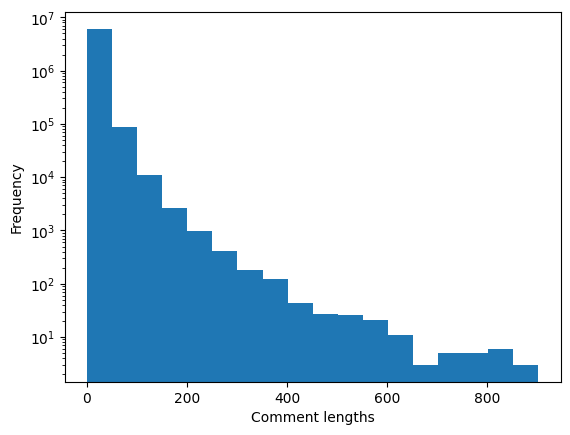

In [8]:
comments = digikala['body']
plt.hist(comments, bins= np.arange(min(comments), max(comments), 50), log=True)
plt.xlabel('Comment lengths')
plt.ylabel('Frequency')
plt.show()

In [9]:
import bisect
from collections import defaultdict

def score_comment(intervals, length):
    return bisect.bisect_left(intervals, length)

def total_score_comment(intervals, lengths):
    local_sum = 0
    lengths_dict = defaultdict(list)
    for length in lengths:
        score = score_comment(intervals, length)
        local_sum += score
        lengths_dict[score].append(length)

    lengths_stats = {}
    for score, lengths in lengths_dict.items():
        lengths_stats[score] = {
            'num' : len(lengths),
            'mean': np.mean(lengths),
            'std': np.std(lengths),
            'sum' : np.sum(lengths)
        }
    return lengths_stats, local_sum

In [10]:
# check function
intervals = [0, 1, 5, 10]
lengths = [0,0,1,2,2,3,6,4,6,20,23,43]

lengths_stats, local_sum = total_score_comment(intervals, lengths)
print(lengths_stats)
print(local_sum)

{0: {'num': 2, 'mean': 0.0, 'std': 0.0, 'sum': 0}, 1: {'num': 1, 'mean': 1.0, 'std': 0.0, 'sum': 1}, 2: {'num': 4, 'mean': 2.75, 'std': 0.82915619758885, 'sum': 11}, 3: {'num': 2, 'mean': 6.0, 'std': 0.0, 'sum': 12}, 4: {'num': 3, 'mean': 28.666666666666668, 'std': 10.208928554075703, 'sum': 86}}
27


### Heuristic-Based

In [11]:
heuristic_intervals = [1, 5, 20, 100, 300, 500, 1000]

lengths_stats, local_sum = total_score_comment(heuristic_intervals, comments)
print(lengths_stats)

{1: {'num': 2396465, 'mean': 3.474248111280574, 'std': 1.0794860488955333, 'sum': 8325914}, 2: {'num': 2606712, 'mean': 10.502521183774808, 'std': 3.970058184475577, 'sum': 27377048}, 0: {'num': 453290, 'mean': 1.0, 'std': 0.0, 'sum': 453290}, 3: {'num': 685376, 'mean': 34.56264006910076, 'std': 14.794550995849688, 'sum': 23688404}, 4: {'num': 15115, 'mean': 138.90956003969566, 'std': 39.753324211691684, 'sum': 2099618}, 5: {'num': 374, 'mean': 362.1764705882353, 'std': 47.01815421776919, 'sum': 135454}, 6: {'num': 81, 'mean': 623.4444444444445, 'std': 111.85970048499412, 'sum': 50499}}


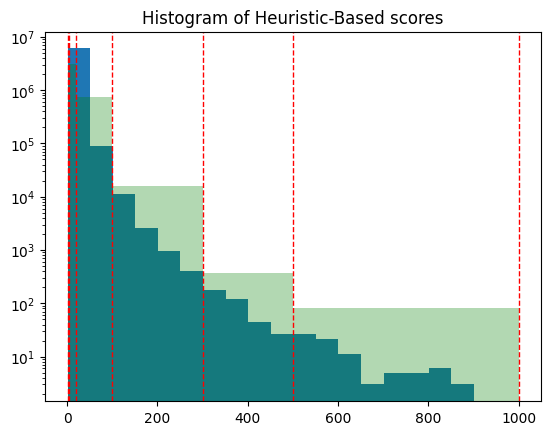

In [12]:
plt.hist(comments, bins= np.arange(min(comments), max(comments), 50), log=True)
for boundary in heuristic_intervals:
    plt.axvline(boundary, color='r', linestyle='dashed', linewidth=1)
plt.hist(comments, bins= heuristic_intervals, log = True, color= 'green', alpha = 0.3)
plt.title('Histogram of Heuristic-Based scores')
plt.show()

### Percentile-Based

In [13]:
percentiles = [10, 25, 50, 75, 90]
percentile_intervals = np.percentile(comments, percentiles)
percentile_intervals = np.append(percentile_intervals, 1000)
print(percentile_intervals)

lengths_stats, local_sum = total_score_comment(percentile_intervals, comments)
print(lengths_stats)

[   2.    3.    6.   12.   22. 1000.]
{1: {'num': 653378, 'mean': 3.0, 'std': 0.0, 'sum': 1960134}, 3: {'num': 1437439, 'mean': 9.042851209686116, 'std': 1.6753782715910588, 'sum': 12998547}, 4: {'num': 848325, 'mean': 16.57400170925058, 'std': 2.7972654651801356, 'sum': 14060140}, 0: {'num': 1021321, 'mean': 1.5561728389017753, 'std': 0.4968345923642145, 'sum': 1589352}, 2: {'num': 1599858, 'mean': 4.862012753631885, 'std': 0.8062235402557909, 'sum': 7778530}, 5: {'num': 597092, 'mean': 39.765269003771614, 'std': 25.046669543336236, 'sum': 23743524}}


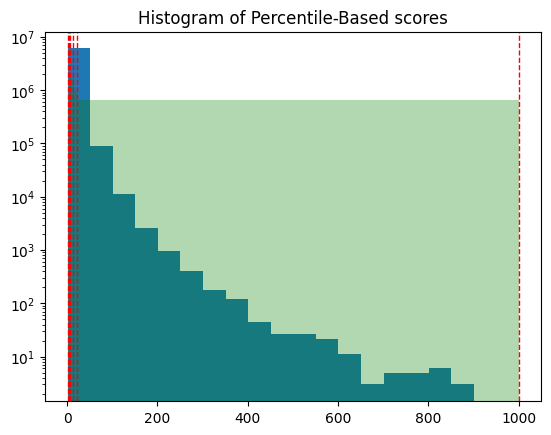

In [14]:
plt.hist(comments, bins= np.arange(min(comments), max(comments), 50), log=True)
for boundary in percentile_intervals:
    plt.axvline(boundary, color='r', linestyle='dashed', linewidth=1)
plt.hist(comments, bins= percentile_intervals, log = True, color= 'green', alpha = 0.3)
plt.title('Histogram of Percentile-Based scores')
plt.show()

### Clustering-Based

In [15]:
n_intervals = 6
comment_lengths_reshaped = np.reshape(comments, (-1, 1))

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_intervals, random_state=42).fit(comment_lengths_reshaped)
clustering_intervals = np.sort(kmeans.cluster_centers_.flatten())
clustering_intervals = np.append(clustering_intervals, 1000)
print(clustering_intervals)

lengths_stats, local_sum = total_score_comment(clustering_intervals, comments)
print(lengths_stats)

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[   4.11168157   12.71915497   26.18009082   49.10488739   96.8293301
  234.91905615 1000.        ]
{0: {'num': 2320261, 'mean': 2.642691490310788, 'std': 1.084812789276981, 'sum': 6131734}, 1: {'num': 2391735, 'mean': 7.607376653349974, 'std': 2.211181614512446, 'sum': 18194829}, 2: {'num': 1003534, 'mean': 17.781784174726518, 'std': 3.84444105375502, 'sum': 17844625}, 3: {'num': 331833, 'mean': 34.75900226921373, 'std': 6.215404393573769, 'sum': 11534184}, 4: {'num': 92525, 'mean': 64.27265063496353, 'std': 12.054931841653408, 'sum': 5946827}, 5: {'num': 16440, 'mean': 129.38801703163017, 'std': 31.071595214244486, 'sum': 2127139}, 6: {'num': 1085, 'mean': 323.4, 'std': 106.46568604084352, 'sum': 350889}}


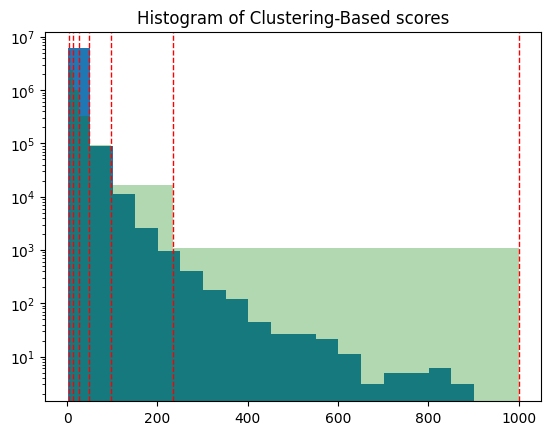

In [16]:
plt.hist(comments, bins= np.arange(min(comments), max(comments), 50), log=True)
for boundary in clustering_intervals:
    plt.axvline(boundary, color='r', linestyle='dashed', linewidth=1)
plt.hist(comments, bins= clustering_intervals, log = True, color= 'green', alpha = 0.3)
plt.title('Histogram of Clustering-Based scores')
plt.show()

### Distribution of Product's Scores

In [17]:
df = digikala[['body', 'product_id']].reset_index(drop=True)
df['score'] = df['body'].apply(lambda comment: score_comment(clustering_intervals, comment))
result = df.groupby('product_id')['score'].sum().reset_index()
result.head()

,product_id,score
0,7602,250
1,12302,13
2,12423,10
3,15327,101
4,15435,187


In [18]:
result['score'].describe()

count    331599.000000
mean         17.651175
std          38.431234
min           0.000000
25%           1.000000
50%           4.000000
75%          13.000000
max         459.000000
Name: score, dtype: float64

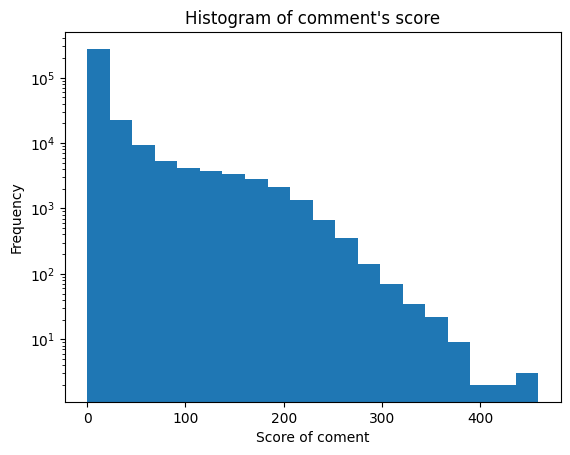

In [19]:
plt.hist(result['score'],bins= 20, log=True)
plt.xlabel('Score of coment')
plt.ylabel('Frequency')
plt.title('Histogram of comment\'s score')
plt.show()

## Rates And Comments Grouping
We want to divide comments into positive and negative groups. In the simplest case, we do this using rates. Otherwise, we refer to the comment sentiment.

### Rates Distribution

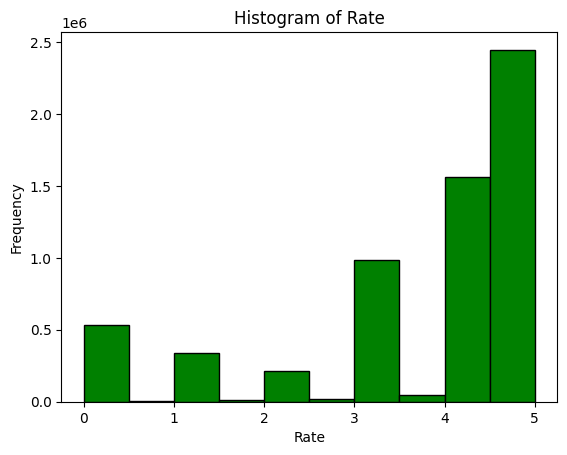

In [20]:
plt.hist(digikala['rate'], color='green', edgecolor='black')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Rate')
plt.show()

### Labeling comments

In [21]:
def label_group(comment):
    if comment['rate'] > 3:
        return "positive"
    if 0 < comment['rate'] < 3:
        return "negative"
    return comment['label']

digikala['sentiment'] = digikala.apply(label_group, axis=1)

In [22]:
digikala = digikala.drop('label', axis=1)
digikala = digikala.rename(columns= {"sentiment" : 'label'})

# Define Scoring Function

In [23]:
grouped_digikala = digikala.groupby(['product_id', 'seller_title'])

## Simple Scoring

In [24]:
def simple_score(group):
    group = group[group['is_buyer']]

    _, comments = total_score_comment(clustering_intervals, group['body'])
    comments_score = comments / 1000
    rates_score = (group['rate'] > 0).sum()
    titles_score = group['title'].sum()
    likes_score = group['likes'].sum() + group['dislikes'].sum()
    recommended_score = group['recommendation_status'].sum()
    advantages_score = group['advantages_count'].sum() + group['disadvantages_count'].sum()
    
    total_score = (comments_score + rates_score + titles_score + 
                   likes_score + recommended_score + advantages_score)
    
    return total_score

simple_df = grouped_digikala.apply(simple_score).reset_index(name='simple_score')
simple_df.head()

KeyboardInterrupt: 

In [ ]:
# Divide by total number
def avg_simple_score(group):
    group = group[group['is_buyer']]

    _, comments = total_score_comment(clustering_intervals, group['body'])
    comments_score = comments / 1000
    rates_score = (group['rate'] > 0).sum()
    titles_score = group['title'].sum()
    likes_score = group['likes'].sum() + group['dislikes'].sum()
    recommended_score = group['recommendation_status'].sum()
    advantages_score = group['advantages_count'].sum() + group['disadvantages_count'].sum()
    
    total_score = (comments_score + rates_score + titles_score + 
                   likes_score + recommended_score + advantages_score) / len(group) * 100
    
    return total_score

avg_simple_df = grouped_digikala.apply(avg_simple_score).reset_index(name='avg_simple_score')
avg_simple_df.head()

,product_id,seller_title,avg_simple_score
0,7602,برزان,350.134375
1,7602,برهان الکترونیک,300.100000
2,7602,به روز سنتر,500.150000
3,7602,جانبی انسی,320.110000
4,7602,جانبی حبیب,200.000000


## Weighted Scoring:

In [ ]:
# by weightes
def weighted_score(group):
    group = group[group['is_buyer']]

    weights = {
        "body" : 10,
        "title" : 3,
        "rate" : 4,
        "likes" : 4,
        "recommendation" : 3,
        "advantages" : 5
    }

    _, comments = total_score_comment(clustering_intervals, group['body'])
    comments_score = weights["body"]*comments / 100
    rates_score =  weights["rate"]*(group['rate'] > 0).sum()
    titles_score =  weights["title"]*group['title'].sum()
    likes_score =  weights["likes"]*(group['likes'].sum() + group['dislikes'].sum())
    recommended_score =  weights["recommendation"]* group['recommendation_status'].sum()
    advantages_score = weights["advantages"]* (group['advantages_count'].sum() + group['disadvantages_count'].sum())
    
    total_score = (comments_score + rates_score + titles_score + 
                   likes_score + recommended_score + advantages_score) / sum(weights.values())
    
    return total_score

weighted_score_df = grouped_digikala.apply(weighted_score).reset_index(name='weighted_score')
weighted_score_df.head()

,product_id,seller_title,weighted_score
0,7602,برزان,14.148276
1,7602,برهان الکترونیک,0.348276
2,7602,به روز سنتر,1.389655
3,7602,جانبی انسی,4.210345
4,7602,جانبی حبیب,0.241379


In [ ]:
# average by weightes 
def avg_weighted_score(group):
    group = group[group['is_buyer']]

    weights = {
        "body" : 10,
        "title" : 3,
        "rate" : 4,
        "likes" : 4,
        "recommendation" : 3,
        "advantages" : 5
    }

    _, comments = total_score_comment(clustering_intervals, group['body'])
    comments_score = weights["body"]*comments / 100
    rates_score =  weights["rate"]*(group['rate'] > 0).sum()
    titles_score =  weights["title"]*group['title'].sum()
    likes_score =  weights["likes"]*(group['likes'].sum() + group['dislikes'].sum())
    recommended_score =  weights["recommendation"]* group['recommendation_status'].sum()
    advantages_score = weights["advantages"]* (group['advantages_count'].sum() + group['disadvantages_count'].sum())
    
    total_score = ((comments_score + rates_score + titles_score + 
                   likes_score + recommended_score + advantages_score) / sum(weights.values())) / len(group) * 100
    
    return total_score

avg_weighted_score_df = grouped_digikala.apply(weighted_score).reset_index(name='avg_weighted_score')
avg_weighted_score_df.head()

,product_id,seller_title,avg_weighted_score
0,7602,برزان,14.148276
1,7602,برهان الکترونیک,0.348276
2,7602,به روز سنتر,1.389655
3,7602,جانبی انسی,4.210345
4,7602,جانبی حبیب,0.241379


### Biased Score

In [28]:
def compute_factors(df):
    """Compute individual score factors."""
    df['body_score'] = df['body'].apply(lambda x: score_comment(clustering_intervals, x) / 1000)
    df['rate_score'] = df['rate'].apply(lambda x: 1 if x > 0 else 0)
    df['advantage_score'] = df['advantages_count'] + df['disadvantages_count']
    df['likes_adjusted'] = df['likes'] + 1
    df['f'] = df.apply(lambda row: row['likes_adjusted'] / (row['likes_adjusted'] + row['dislikes']) 
                       if (row['likes_adjusted'] + row['dislikes']) != 0 else 0, axis=1)
    return df

def compute_scores(df):
    """Compute total, positive, and negative scores."""
    df['score'] = (df['body_score'] + df['rate_score'] + df['title'] + 
                   df['recommendation_status'] + df['advantage_score'])
    
    df['pos_score'] = df.apply(lambda row: row['f'] * row['score'] if row['label'] == 'positive' 
                               else row['score'] - row['f'] * row['score'], axis=1)
    df['neg_score'] = df.apply(lambda row: row['score'] - row['pos_score'], axis=1)
    
    return df

def biased_score(group):
    group = compute_factors(group)
    group = compute_scores(group)
    
    total_score = group['score'].sum()
    total_positive_score = group['pos_score'].sum()
    total_negative_score = group['neg_score'].sum()
    
    return total_score, total_positive_score, total_negative_score

result = grouped_digikala.apply(lambda x: pd.Series(biased_score(x)))
result = result.reset_index()

#biased_score_grouped = grouped_digikala.apply(lambda group: pd.Series(biased_score(group), index=['biased_score', 'biased_positive_score', 'biased_negative_score']))
#biased_score_df = biased_score_grouped.reset_index()
#biased_score_df.head()

In [31]:
result.rename(columns={0:'total_biased_score',1:'total_pos_score',2:'total_neg_score'}, inplace=True)
result.head()

,product_id,seller_title,total_biased_score,total_pos_score,total_neg_score
0,7602,برزان,99.043,71.53100,27.51200
1,7602,برهان الکترونیک,3.001,3.00100,0.00000
2,7602,به روز سنتر,10.003,3.00100,7.00200
3,7602,جانبی انسی,29.011,19.50725,9.50375
4,7602,جانبی حبیب,2.000,2.00000,0.00000


In [32]:
result['total_biased_score'] = result['total_pos_score'] - result['total_neg_score']
result.head()

,product_id,seller_title,total_biased_score,total_pos_score,total_neg_score
0,7602,برزان,44.0190,71.53100,27.51200
1,7602,برهان الکترونیک,3.0010,3.00100,0.00000
2,7602,به روز سنتر,-4.0010,3.00100,7.00200
3,7602,جانبی انسی,10.0035,19.50725,9.50375
4,7602,جانبی حبیب,2.0000,2.00000,0.00000


In [34]:
simple_df = pd.read_csv('new_products.csv')
simple_df.head()

,product_id,seller_title,simple_score,avg_simple_score,weighted_score,avg_weighted_score
0,7602,برزان,112.047,350.146875,14.162069,44.256466
1,7602,برهان الکترونیک,3.001,300.100000,0.348276,34.827586
2,7602,به روز سنتر,10.003,500.150000,1.389655,69.482759
3,7602,جانبی انسی,32.012,320.120000,4.213793,42.137931
4,7602,جانبی حبیب,2.000,200.000000,0.241379,24.137931


In [35]:
result = (simple_df.merge(result, on=['product_id', 'seller_title'], how='inner'))
result.head()

,product_id,seller_title,simple_score,avg_simple_score,weighted_score,avg_weighted_score,total_biased_score,total_pos_score,total_neg_score
0,7602,برزان,112.047,350.146875,14.162069,44.256466,44.0190,71.53100,27.51200
1,7602,برهان الکترونیک,3.001,300.100000,0.348276,34.827586,3.0010,3.00100,0.00000
2,7602,به روز سنتر,10.003,500.150000,1.389655,69.482759,-4.0010,3.00100,7.00200
3,7602,جانبی انسی,32.012,320.120000,4.213793,42.137931,10.0035,19.50725,9.50375
4,7602,جانبی حبیب,2.000,200.000000,0.241379,24.137931,2.0000,2.00000,0.00000


In [36]:
result.to_csv('result.csv', index=False)